Adapted by Carlos Toxtli https://www.carlostoxtli.com/#colab-overfit-2

Source: https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/02_exploring_overfitting/Regularization.ipynb

# Exploring overfitting

### Imports

In [ ]:
import numpy as np

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Settings

In [ ]:
# number of samples in the data set
N_SAMPLES = 2000
# ratio between training and test sets
TEST_SIZE = 0.2
# boundary of the graph
GRID_PADDING = 0.5
GRID_STEP = 0.01
# number of iterations of the neural network
N_EPOCHS = 200
# index of the layer we want to visualize
LAYER_INDEX = 2
# directory in which the visualizations will be saved
OUTPUT_DIR = "l2_visualizations"

### Create artificial dataset

In [ ]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.4, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=42)

### Definition of grid

In [ ]:
x_min, x_max = X[:, 0].min() - GRID_PADDING, X[:, 0].max() + GRID_PADDING
y_min, y_max = X[:, 1].min() - GRID_PADDING, X[:, 1].max() + GRID_PADDING
XX, YY = np.meshgrid(np.arange(x_min, x_max, GRID_STEP), np.arange(y_min, y_max, GRID_STEP))

### Auxiliary plotting function

In [ ]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name, XX=None, YY=None, preds=None):
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    axes = plt.gca()
    axes.set_xlim([x_min,x_max])
    axes.set_ylim([y_min,y_max])
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 0.6, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    # plt.savefig(file_name)
    # plt.close()

In [ ]:
# the function of creating a weight matrix graph
def plot_weights_matrix(model, layer_index, plot_name, file_name):
    weights = model.layers[LAYER_INDEX].get_weights()[0]
    min_val = round(weights.min(), 2)
    max_val = round(weights.max(), 2)
    mean_val = round(weights.mean(), 2)
    shape = weights.shape
    X = np.array(range(shape[1]))
    Y = np.array(range(shape[0]))
    X, Y = np.meshgrid(X, Y)
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    plt.title("\n" + plot_name + "\n[MIN: " + str(min_val) + ", MAX: " + str(max_val) + ", MEAN: " + str(mean_val) + "]", fontsize=20, y=1.05)
    surf = ax.plot_surface(X, Y, weights, cmap=plt.get_cmap('rainbow'), linewidth=0)
    plt.savefig("./" + OUTPUT_DIR + "/" + file_name + ".png")
    # plt.close()

### Visualization of the data set

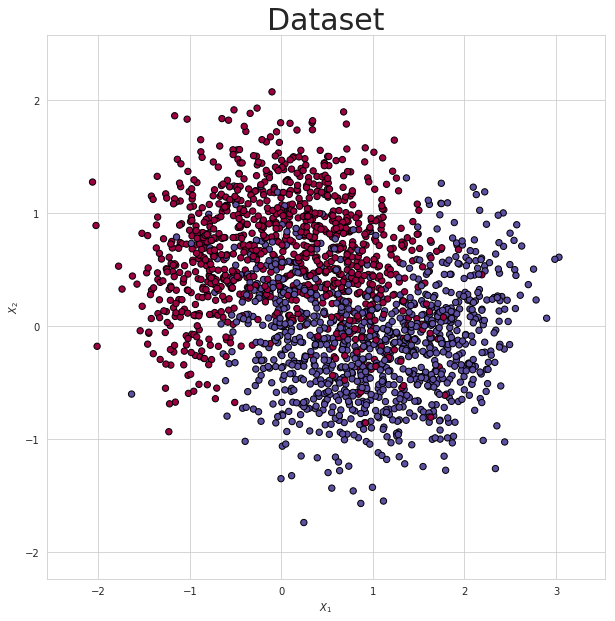

In [ ]:
make_plot(X, y, "Dataset", "dataset.png")

### Neural network without regularisation (high variance)

In [ ]:
model_1 = Sequential()
model_1.add(Dense(8, input_dim=2,activation='relu'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model_1.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)

In [ ]:
y_train_pred_2 = model_1.predict_classes(X_train)
y_test_pred_2 = model_1.predict_classes(X_test)
train_acc = accuracy_score(y_train, y_train_pred_2)
test_acc = accuracy_score(y_test, y_test_pred_2)
print("Train accuracy: " + str(train_acc))
print("Test accuracy: " + str(test_acc))

Train accuracy: 0.879375
Test accuracy: 0.875


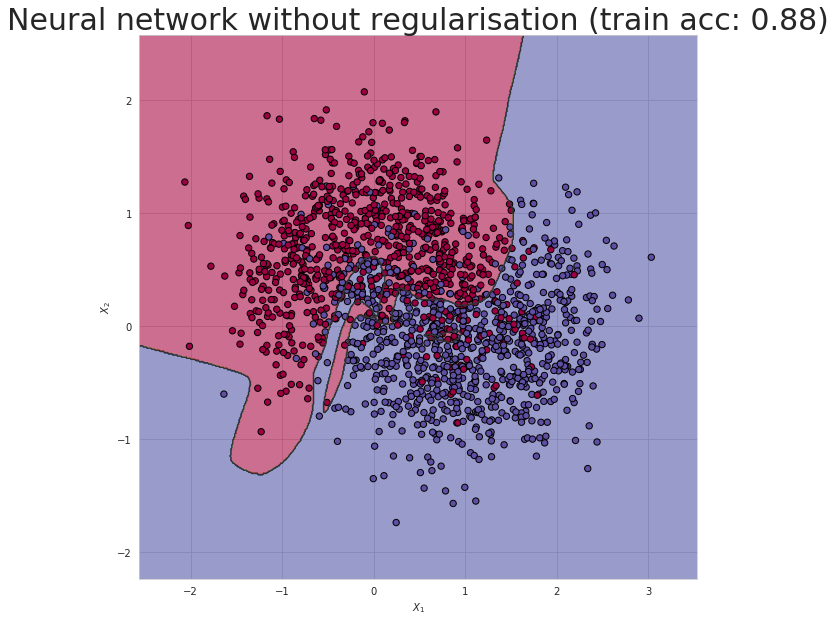

In [ ]:
preds = model_1.predict_classes(np.c_[XX.ravel(), YY.ravel()])
title = "Neural network without regularisation (train acc: {0:.2f})".format(train_acc)
file = "nn_train.png"
make_plot(X_train, y_train, title, file, XX, YY, preds)

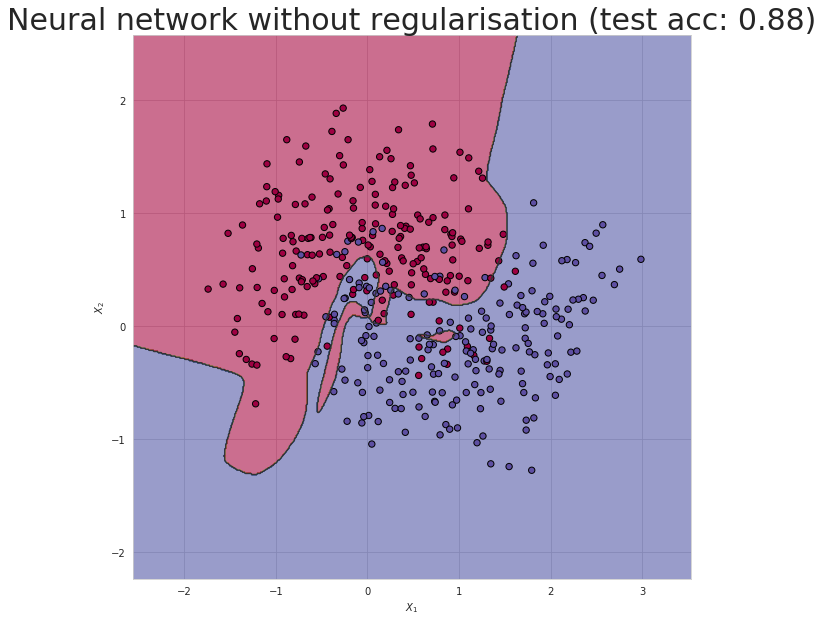

In [ ]:
preds = model_1.predict_classes(np.c_[XX.ravel(), YY.ravel()])
title = "Neural network without regularisation (test acc: {0:.2f})".format(test_acc)
file = "nn_test.png"
make_plot(X_test, y_test, title, file, XX, YY, preds)

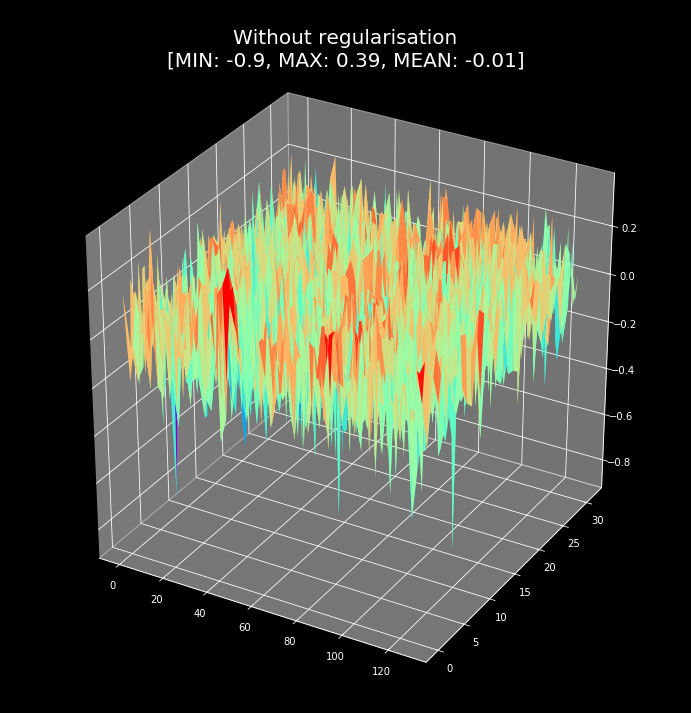

In [ ]:
plot_weights_matrix(model_1, LAYER_INDEX, "Without regularisation", "without_regularisation")

### Neural network with regularisation

In [ ]:
def build_model_with_regularization(_lambda):
    model = Sequential()
    model.add(Dense(8, input_dim=2,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(_lambda)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    return model

== MODEL FOR LAMBDA 1e-05 ==
== MODEL FOR LAMBDA 0.0001 ==
== MODEL FOR LAMBDA 0.001 ==
== MODEL FOR LAMBDA 0.01 ==
== MODEL FOR LAMBDA 0.1 ==
== MODEL FOR LAMBDA 1 ==


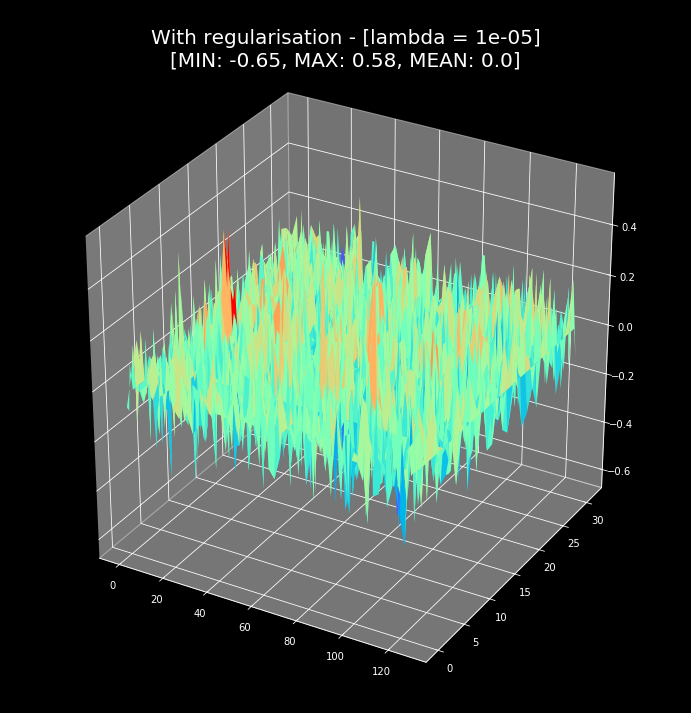

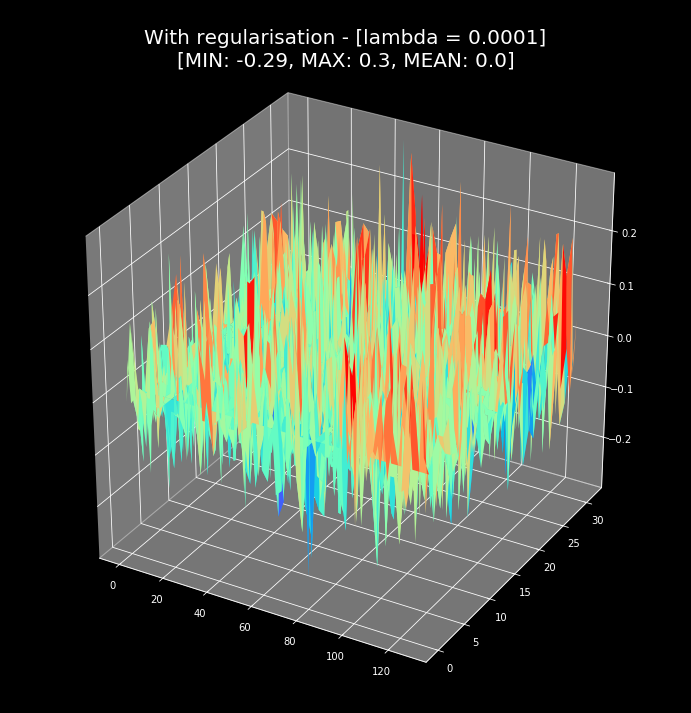

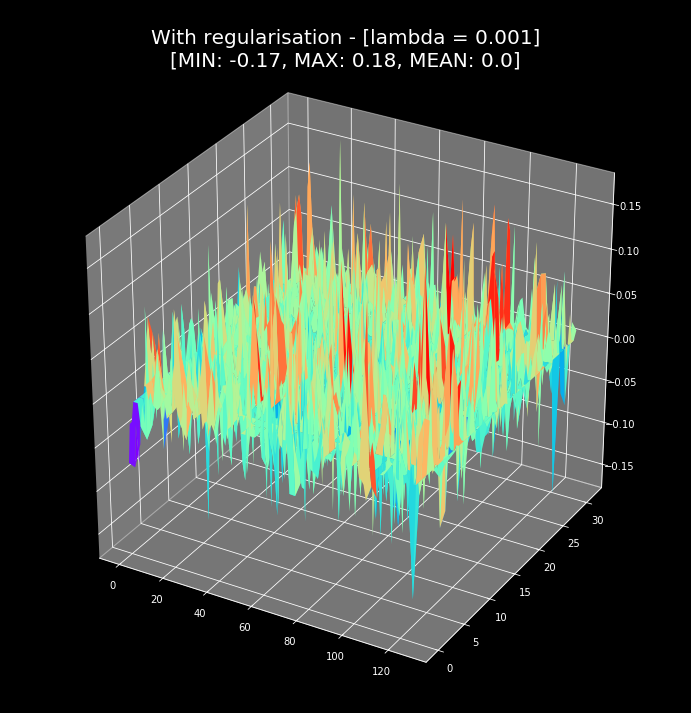

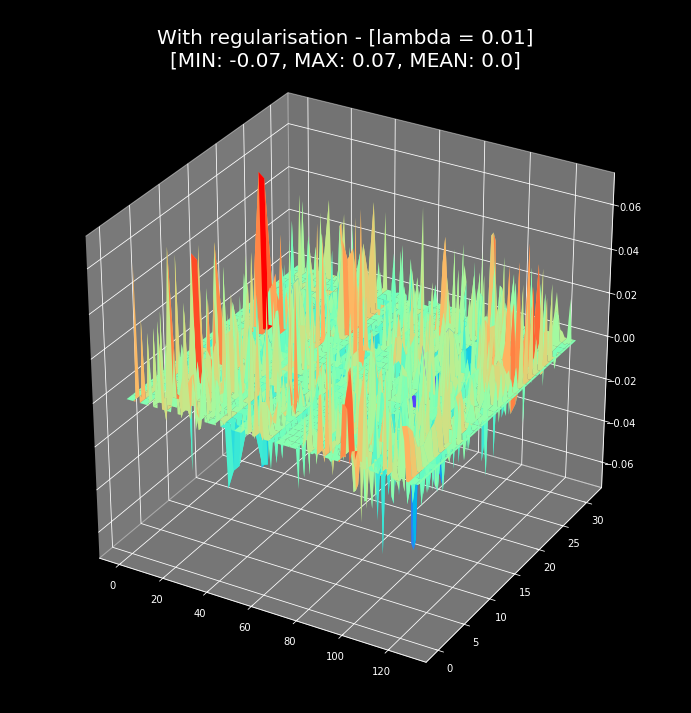

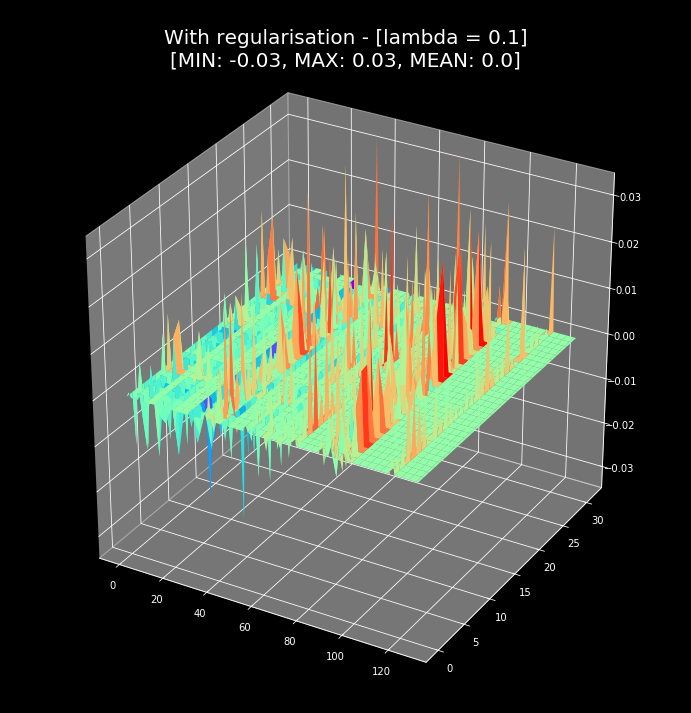

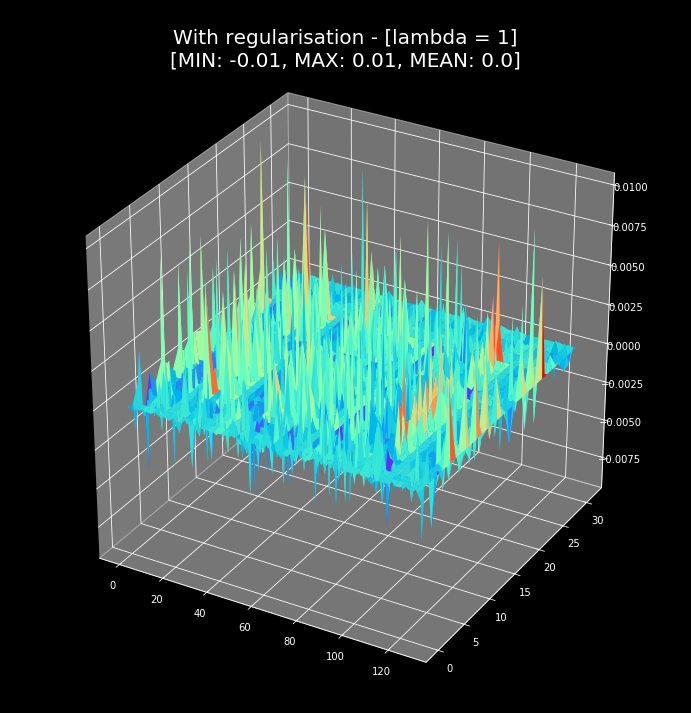

In [ ]:
for i in range(-5, 1):
    _lambda = 10**i
    print("== MODEL FOR LAMBDA {} ==".format(str(_lambda)))
    model = build_model_with_regularization(_lambda)
    history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)
    layer_index = 2
    plot_title = "With regularisation - [lambda = {}]".format(str(_lambda))
    file_name = "with_regularisation_" + str(_lambda)
    plot_weights_matrix(model, layer_index, plot_title, file_name)

## Thank you
---